## Data Processing

In [1]:
# Download Data 
#!pip install scipy.io

#import scipy.io
#mat = scipy.io.loadmat('file.mat')

In [2]:
print("Hello World")

Hello World


In [3]:

#!pip install sciPy
#!pip install h5py
#import scipy.io
#!pip install tables
#!pip install matlab.engine
#import matlab.engine
#!pip install mat4py

In [4]:
import pickle
import pandas as pd
import numpy as np 
import scipy
import seaborn as sns
import sklearn.metrics 
import h5py
import tables



In [6]:
import scipy.io as sio
#f = sio.loadmat('Data/sub000/After_remarks.mat')
#print(f)
#with open(Data/sub000/A)

In [10]:
f = sio.loadmat('dataset/raw_data/sub000/After_remarks.mat')
print(f.keys())
movie_idx_list = []

for i in range(0,28):
    #print(f["After_remark"][i][0][1],f["After_remark"][i][0][2][0][0])#,f["After_remark"][i][0][0])
    movie_idx_list.append(f["After_remark"][i][0][2][0][0])
print(movie_idx_list)

dict_keys(['__header__', '__version__', '__globals__', 'After_remark'])
[11, 8, 2, 5, 6, 9, 3, 12, 20, 17, 26, 23, 13, 15, 14, 16, 10, 1, 4, 7, 28, 25, 22, 19, 18, 21, 27, 24]


# Desciption of array 
- 1) First array is movie 
- 2) Second is Electrodes 
- 3) Third is seconds (Timeseries)
- 4) Fourth is frequency bands
- - 4.1: Delta band &rarr; 1-4 Hz, When people are sleeping, stage 2 NREM sleep, woemn seems to have more Delta-activity but is first apparent in early adulthood (30-40)
- - 4.2: Theta band &rarr; 4-8 Hz, learning, memory and spatial Navigation, meditation can increase theta waves, can appear in sleep but not the deepest stages, active stages, the more movement the higher the theta state
- - 4.3: Alpha band &rarr; 8-14 Hz, Two types with Type I being centered around occipital lobe, Type II happens during REM-sleep and is located at frontal-location in the brain, Not significantly linked to people with any major sleep disorder, chronic fatigue syndrome and major depression, alpha waves indicate idlenss, and mistakes are often happening when people are doing something automatically. 
- - 4.4: Beta band  &rarr; 14-30 Hz, can be seperated into three kinds of waves. Associated with waking consciousness, beta waves are accociated with the muscle contractions that happen in isotonic movements indicative of inhibitory cortical transmission mediated by gamma aminobutyric acid (GABA), the principal inhibitory neurotransmitter of the mammalian nervous system. Benzodiazepines, drugs that modulate GABAA receptors, induce beta waves in EEG recordings from humans and rats
- - 4.5: Gamma Band &rarr; 30-47 Hz, Altered gamma activity has been observed in many mood and cognitive disorders such as Alzheimer's disease, epilepsy and schizophrenia For clinical relevance can be biomarker between unipolar and bipolar disorder, decrease Gamma activity is obser in schizophrenia  

# Describtion of metrics: 
- 1) Differential entropy: $DE = \frac{1}{2}ln(2\pi e \sigma^2)$, Shannon entropy on continuous functions, assumes normal distribution. 
- 2) Power Spectral density: $PSD =E[X^2]$, exists for stationary processes, power of a signal or time series distruted over frequency 
- 3) Where x is the EEG signal and $\sigma$ is the variance of the signal


In [15]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader

In [16]:
class CustomEEGDataset(Dataset):
    def __init__(self, annotations_file, eeg_file, transform=None, target_transform=None):
        self.eeg_labels = torch.from_numpy(np.load(annotations_file).reshape(-1,1))
        self.eeg_data = torch.from_numpy(np.load(eeg_file))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.eeg_labels)

    def __getitem__(self, idx):
        label = self.eeg_labels[idx]
        eeg = self.eeg_data[idx]
        if self.transform:
            eeg = self.transform(eeg)
        if self.target_transform:
            label = self.target_transform(label)
        return eeg, label

In [36]:

eeg_DE_dataset = CustomEEGDataset('label_valence_no_neutral_DE.npy','eeg_data_no_neutral_DE.npy')
eeg_DE_dataset[0][0].shape # gives [32,30,5]
trainloader = torch.utils.data.DataLoader(eeg_DE_dataset, batch_size=4,
                                          shuffle=True, num_workers=2)

In [19]:
batch_size = 32
def custom_collate_fn(batch):
    # Extract inputs and targets from the batch
    inputs, targets = zip(*batch)
    
    # Convert to tensors and adjust shapes as needed
    inputs = torch.stack(inputs)
    targets = torch.tensor(targets)
    
    # Perform any additional transformations or reshaping
    inputs = inputs.transpose(1, 2)  # Adjust shape as needed

    return inputs, targets

# Create a data loader with the custom collate function
train_loader = DataLoader(eeg_DE_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
print(train_loader)


# GCN PART 

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        # Initialize weights and biases
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = nn.Parameter(torch.FloatTensor(out_features))
        nn.init.xavier_uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, input, adj):
        # Perform graph convolution
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        return output + self.bias
    

    def train(model, device, train_loader, optimizer, epoch):
        model.train()
        correct = 0
        train_acc = []
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = nn.functional.binary_cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            output = model(data)
            correct = int(sum(output.eq(target))[0])
            train_acc.append(correct/target.shape[0])
        return train_acc


class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass):
        # Properly initialize the superclass
        super(GCN, self).__init__()

        # Initialize layers
        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)

    def forward(self, x, adj):
        # First graph convolution layer
        x = self.gc1(x, adj)
        # Second graph convolution layer
        x = self.gc2(x, adj)
        return x



In [24]:
import networkx as nx
import torchvision


DiG = nx.complete_graph(32)
adj = nx.normalized_laplacian_matrix(DiG).toarray()
adj = torch.tensor(adj)
adj = adj.to(torch.float32)

In [25]:
import time
def calculate_accuracy(predictions, labels):
    _, predicted_labels = torch.max(predictions, 1)
    correct_predictions = (predicted_labels == labels).sum().item()
    total_predictions = labels.size(0)
    accuracy = correct_predictions / total_predictions
    return accuracy

In [26]:
def custom_collate_fn(batch):
    # Extract inputs and targets from the batch
    inputs, targets = zip(*batch)
    
    # Convert to tensors and adjust shapes as needed
    inputs = torch.stack(inputs)
    targets = torch.tensor(targets)
    
    # Perform any additional transformations or reshaping
    inputs = inputs.transpose(1, 2)  # Adjust shape as needed

    return inputs, targets

# Create a data loader with the custom collate function
train_loader = DataLoader(eeg_DE_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
print(train_loader)

In [27]:
from tqdm import tqdm

## Time Series GCN

In [125]:
import networkx as nx
import torchvision


DiG = nx.complete_graph(32)
adj = nx.normalized_laplacian_matrix(DiG).toarray()
adj = torch.tensor(adj)
adj = adj.to(torch.float32)
#print(adj.shape)

# Add a batch dimension at the beginning to make it 3D
total_list = []
for i in range(30): 
    total_list.append(adj)

stacked_tensor = torch.stack(total_list, dim=2)

stacked_tensor = stacked_tensor.moveaxis(1,2)
stacked_tensor = stacked_tensor.moveaxis(0,1)
print(stacked_tensor.shape) # torch.Size([30, 32, 32])


torch.Size([30, 32, 32])


In [29]:
eeg_DE_dataset[1][1]

tensor([0.])

In [30]:
# Define the number of folds and batch size
k_folds = 5
batch_size = 32

# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the k-fold cross validation
kf = KFold(n_splits=k_folds, shuffle=True)

# Loop through each fold
for fold, (train_idx, test_idx) in enumerate(kf.split(eeg_DE_dataset)):
    print(f"Fold {fold + 1}")
    print("-------")
    all_accs_train = []
    # Define the data loaders for the current fold
    train_loader = DataLoader(
        dataset=eeg_DE_dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
        collate_fn=custom_collate_fn
    )

    test_loader = DataLoader(
        dataset=eeg_DE_dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(test_idx),
        collate_fn=custom_collate_fn
    )



        


Fold 1
-------
Fold 2
-------
Fold 3
-------
Fold 4
-------
Fold 5
-------


In [149]:
def get_predictions(output, labels):
    preds = torch.max(output, dim=1)[1]
    
    preds = preds.type_as(labels)
    
    return preds

def graph_structure_majority(predictions):
    # Sum the likelihoods for class 0 and class 1
    total_class_0 = predictions[:, 0].sum()
    total_class_1 = predictions[:, 1].sum()
    
    # Determine which class is more likely for the entire graph
    if total_class_0 > total_class_1:
        return 0  # Graph is more likely to belong to class 0
    else:
        return 1  # Graph is more likely to belong to class 1



def accuracy(pred, labels):
    count = 0
    for i in range(pred.shape[0]):
        if pred[i].item() ==  labels[i].item():
            count +=1 
    acc = count/pred.shape[0]
    
    return acc


def calculate_accuracy(predictions, targets): ### For each epoch
    correct = (predictions == targets).float()
    accuracy = correct.mean().item() * 100
    
    return accuracy


In [ ]:
import networkx as nx
import torchvision


DiG = nx.complete_graph(32)
adj = nx.normalized_laplacian_matrix(DiG).toarray()
adj = torch.tensor(adj)
adj = adj.to(torch.float32)

In [150]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)

    def forward(self, x, adj):
        x = self.gc1(x, adj)
        x = self.gc2(x, adj)
        return x

In [192]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv  # PyTorch Geometric's GCN layer
from torch.nn import Parameter
import math
from torch_geometric.data import Data

class TimeSeriesGNN(nn.Module):
    def __init__(self, time_steps, nodes, num_features, num_classes):
        super(TimeSeriesGNN, self).__init__()
        # Initialize weights and biases
        self.gcn = GCNConv(in_channels=num_features, out_channels=num_classes)  # num_features=5, num_classes=2
        self.activation = torch.nn.Sequential(torch.nn.Dropout(p=0.8),
                                              # torch.nn.BatchNorm1d(32),
                                                       torch.nn.Linear(32,2,bias=True))

         # Define the MLP using nn.Conv1d layers
        self.mlp = nn.Sequential(
            nn.Linear(960, 480),
            nn.ReLU(),
            nn.Linear(480, 240),
            nn.Tanh(),
            nn.Linear(240, 120),
            nn.Tanh(),
            nn.Linear(120, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Sigmoid()  # Sigmoid activation for probabilities
        )
        #nitialize an LSTM layer
        #self.rnn = nn.RNN(input_size=num_features, hidden_size=num_features, num_layers=1, dropout = 0.6)
        #self.lstm = nn.LSTM(input_size=time_steps, hidden_size=num_features, batch_first=True, dropout = 0.6)# bidirectional=True
 
        self.weight = Parameter(torch.FloatTensor(num_classes, nodes))
        self.bias = Parameter(torch.FloatTensor(num_features))
        #self.reset_parameters()
        self.fc = nn.Linear(nodes, 1)  # From num_features to 1 for binary classification

    #def reset_parameters(self):
    #    stdv = 1. / math.sqrt(self.weight.size(1))
    #    self.weight.data.uniform_(-stdv, stdv)
    #   self.bias.data.uniform_(-stdv, stdv)
    

    

    def forward(self, x, adj):
        final_output_list = []
        for batch in x: 
            # Perform a one-dimensional Fourier transform along axis 1 (sequence length dimension)
            fft_result = torch.fft.fft(batch, dim=1)

            # Compute the magnitude and phase of the Fourier transform
            fft_magnitude = torch.abs(fft_result)  # Magnitude
            fft_phase = torch.angle(fft_result)   # Phase
            # Reshape the input from shape (30, 32, 5) to (30 * 32, 5)
            flattened_tensor = fft_phase.flatten(0, 1)
            flattened_tensor = flattened_tensor.T
            #print(flattened_tensor)
        # Pass the flattened input through the MLP
            mlp_output = self.mlp(flattened_tensor)
            #print(mlp_output)
           
            mlp_output_T = mlp_output.T

            adj = adj.to_sparse()
            graph_features = self.gcn(mlp_output_T, adj)
            
            support = torch.mm(graph_features, self.weight)
            output = torch.spmm(adj, support)

            activation = self.activation(output)
            pred = graph_structure_majority(activation)
   
            final_output_list.append(pred)

        predictions_tensor = torch.tensor(final_output_list)

        return predictions_tensor

model = TimeSeriesGNN(30, 32, 5, 2)

# Switch model to train mode
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
for name, param in model.named_parameters():
    param.requires_grad = True  

epochs = 100

# Training loop
loss_list = []
accuracy_list = []
for epoch in tqdm(range(epochs)):
    # Initialize lists to gather all outputs and targets for the epoch
    epoch_predictions = []
    epoch_targets = []
   # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)

    # Iterate over each batch in the train_loader
    for inputs, targets in train_loader:
        # Forward pass: get model outputs using all inputs
        outputs = model(inputs, adj)
        
        outputs = outputs.to(torch.float32)
        outputs = outputs.requires_grad_(True)
        acc = accuracy(outputs, targets)
        
        # Print accuracy
        #print(f"Accuracy: {acc}")

        targets = targets.float()

        loss = F.mse_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2)
        optimizer.step()
        
        # Store predictions and targets for the epoch
        epoch_predictions.append(outputs)
        epoch_targets.append(targets)
        #predictions = majority_to_all(predictions)

    # Concatenate all predictions and targets for the epoch
    epoch_predictions = torch.cat(epoch_predictions)
    epoch_targets = torch.cat(epoch_targets)

    # Calculate the accuracy for the epoch
    #print(epoch_predictions, epoch_targets)
    epoch_accuracy = calculate_accuracy(epoch_predictions, epoch_targets)
    accuracy_list.append(epoch_accuracy)
    loss_list.append(loss.item())
    # Print total loss and accuracy at the end of each epoch
    print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}, Accuracy: {epoch_accuracy:.2f}%")
        



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:10<17:33, 10.64s/it]

Epoch 1, Loss: 0.5938, Accuracy: 48.78%


  2%|▏         | 2/100 [00:20<16:46, 10.27s/it]

Epoch 2, Loss: 0.5312, Accuracy: 49.48%


  3%|▎         | 3/100 [00:31<16:50, 10.42s/it]

Epoch 3, Loss: 0.5625, Accuracy: 49.44%


  4%|▍         | 4/100 [00:41<16:36, 10.38s/it]

Epoch 4, Loss: 0.5938, Accuracy: 50.35%


  5%|▌         | 5/100 [00:52<16:36, 10.49s/it]

Epoch 5, Loss: 0.5312, Accuracy: 49.96%


  6%|▌         | 6/100 [01:03<16:48, 10.73s/it]

Epoch 6, Loss: 0.4062, Accuracy: 49.05%


  7%|▋         | 7/100 [01:14<16:52, 10.88s/it]

Epoch 7, Loss: 0.4375, Accuracy: 49.26%


  8%|▊         | 8/100 [01:25<16:46, 10.94s/it]

Epoch 8, Loss: 0.5938, Accuracy: 51.48%


  9%|▉         | 9/100 [01:36<16:24, 10.82s/it]

Epoch 9, Loss: 0.4062, Accuracy: 49.39%


 10%|█         | 10/100 [01:47<16:12, 10.81s/it]

Epoch 10, Loss: 0.5312, Accuracy: 50.78%


 11%|█         | 11/100 [01:57<15:49, 10.67s/it]

Epoch 11, Loss: 0.4688, Accuracy: 50.69%


 12%|█▏        | 12/100 [02:08<15:44, 10.73s/it]

Epoch 12, Loss: 0.5312, Accuracy: 50.04%


 13%|█▎        | 13/100 [02:18<15:21, 10.59s/it]

Epoch 13, Loss: 0.6250, Accuracy: 51.00%


 14%|█▍        | 14/100 [02:28<15:02, 10.49s/it]

Epoch 14, Loss: 0.5625, Accuracy: 49.83%


 15%|█▌        | 15/100 [02:39<14:45, 10.42s/it]

Epoch 15, Loss: 0.4688, Accuracy: 49.31%


 16%|█▌        | 16/100 [02:49<14:30, 10.36s/it]

Epoch 16, Loss: 0.6250, Accuracy: 51.65%


 17%|█▋        | 17/100 [02:59<14:12, 10.27s/it]

Epoch 17, Loss: 0.4688, Accuracy: 50.17%


 18%|█▊        | 18/100 [03:09<14:09, 10.36s/it]

Epoch 18, Loss: 0.4375, Accuracy: 48.83%


 19%|█▉        | 19/100 [03:20<13:59, 10.36s/it]

Epoch 19, Loss: 0.5312, Accuracy: 50.74%


 20%|██        | 20/100 [03:30<13:43, 10.30s/it]

Epoch 20, Loss: 0.5625, Accuracy: 49.35%


 21%|██        | 21/100 [03:40<13:26, 10.21s/it]

Epoch 21, Loss: 0.5000, Accuracy: 49.52%


 22%|██▏       | 22/100 [03:50<13:20, 10.26s/it]

Epoch 22, Loss: 0.5625, Accuracy: 48.05%


 23%|██▎       | 23/100 [04:00<13:05, 10.20s/it]

Epoch 23, Loss: 0.5938, Accuracy: 49.65%


 24%|██▍       | 24/100 [04:11<12:53, 10.18s/it]

Epoch 24, Loss: 0.5000, Accuracy: 52.65%


 25%|██▌       | 25/100 [04:21<12:43, 10.18s/it]

Epoch 25, Loss: 0.4375, Accuracy: 47.35%


 26%|██▌       | 26/100 [04:31<12:39, 10.26s/it]

Epoch 26, Loss: 0.4062, Accuracy: 51.52%


 27%|██▋       | 27/100 [04:41<12:21, 10.16s/it]

Epoch 27, Loss: 0.4688, Accuracy: 51.30%


 28%|██▊       | 28/100 [04:51<12:09, 10.13s/it]

Epoch 28, Loss: 0.5000, Accuracy: 51.09%


 29%|██▉       | 29/100 [05:02<12:09, 10.27s/it]

Epoch 29, Loss: 0.4688, Accuracy: 50.95%


 30%|███       | 30/100 [05:12<11:57, 10.25s/it]

Epoch 30, Loss: 0.5938, Accuracy: 49.83%


 31%|███       | 31/100 [05:22<11:52, 10.32s/it]

Epoch 31, Loss: 0.6250, Accuracy: 49.13%


 32%|███▏      | 32/100 [05:32<11:24, 10.07s/it]

Epoch 32, Loss: 0.4688, Accuracy: 50.13%


 33%|███▎      | 33/100 [05:42<11:12, 10.03s/it]

Epoch 33, Loss: 0.5000, Accuracy: 51.26%


 34%|███▍      | 34/100 [05:52<10:59, 10.00s/it]

Epoch 34, Loss: 0.5938, Accuracy: 50.69%


 35%|███▌      | 35/100 [06:02<10:45,  9.93s/it]

Epoch 35, Loss: 0.5000, Accuracy: 51.69%


 36%|███▌      | 36/100 [06:12<10:39, 10.00s/it]

Epoch 36, Loss: 0.3438, Accuracy: 49.35%


 37%|███▋      | 37/100 [06:21<10:22,  9.89s/it]

Epoch 37, Loss: 0.6250, Accuracy: 49.87%


 38%|███▊      | 38/100 [06:31<10:06,  9.79s/it]

Epoch 38, Loss: 0.4688, Accuracy: 50.22%


 39%|███▉      | 39/100 [06:40<09:52,  9.71s/it]

Epoch 39, Loss: 0.5625, Accuracy: 50.35%


 40%|████      | 40/100 [06:50<09:39,  9.66s/it]

Epoch 40, Loss: 0.6250, Accuracy: 46.44%


 41%|████      | 41/100 [06:59<09:27,  9.62s/it]

Epoch 41, Loss: 0.4062, Accuracy: 49.22%


 42%|████▏     | 42/100 [07:10<09:31,  9.85s/it]

Epoch 42, Loss: 0.5312, Accuracy: 50.35%


 43%|████▎     | 43/100 [07:20<09:19,  9.81s/it]

Epoch 43, Loss: 0.3750, Accuracy: 50.39%


 44%|████▍     | 44/100 [07:29<09:05,  9.75s/it]

Epoch 44, Loss: 0.4688, Accuracy: 50.74%


 45%|████▌     | 45/100 [07:39<08:52,  9.68s/it]

Epoch 45, Loss: 0.6250, Accuracy: 51.13%


 46%|████▌     | 46/100 [07:48<08:41,  9.66s/it]

Epoch 46, Loss: 0.3750, Accuracy: 51.43%


 47%|████▋     | 47/100 [07:58<08:30,  9.63s/it]

Epoch 47, Loss: 0.4688, Accuracy: 48.83%


 48%|████▊     | 48/100 [08:08<08:24,  9.70s/it]

Epoch 48, Loss: 0.5000, Accuracy: 49.78%


 49%|████▉     | 49/100 [08:18<08:18,  9.77s/it]

Epoch 49, Loss: 0.3125, Accuracy: 49.70%


 50%|█████     | 50/100 [08:27<08:05,  9.72s/it]

Epoch 50, Loss: 0.5000, Accuracy: 50.26%


 51%|█████     | 51/100 [08:37<07:53,  9.66s/it]

Epoch 51, Loss: 0.3125, Accuracy: 50.74%


 52%|█████▏    | 52/100 [08:46<07:41,  9.61s/it]

Epoch 52, Loss: 0.4688, Accuracy: 49.74%


 53%|█████▎    | 53/100 [08:56<07:31,  9.61s/it]

Epoch 53, Loss: 0.4062, Accuracy: 50.04%


 54%|█████▍    | 54/100 [09:05<07:20,  9.58s/it]

Epoch 54, Loss: 0.5000, Accuracy: 50.04%


 55%|█████▌    | 55/100 [09:15<07:11,  9.58s/it]

Epoch 55, Loss: 0.5000, Accuracy: 49.22%


 56%|█████▌    | 56/100 [09:25<07:04,  9.65s/it]

Epoch 56, Loss: 0.4688, Accuracy: 49.70%


 57%|█████▋    | 57/100 [09:34<06:51,  9.58s/it]

Epoch 57, Loss: 0.5312, Accuracy: 49.96%


 58%|█████▊    | 58/100 [09:44<06:41,  9.55s/it]

Epoch 58, Loss: 0.5312, Accuracy: 48.74%


 59%|█████▉    | 59/100 [09:53<06:30,  9.51s/it]

Epoch 59, Loss: 0.4688, Accuracy: 49.31%


 60%|██████    | 60/100 [10:03<06:21,  9.54s/it]

Epoch 60, Loss: 0.4062, Accuracy: 50.82%


 61%|██████    | 61/100 [10:12<06:12,  9.55s/it]

Epoch 61, Loss: 0.4688, Accuracy: 49.44%


 62%|██████▏   | 62/100 [10:22<06:05,  9.62s/it]

Epoch 62, Loss: 0.4688, Accuracy: 50.74%


 63%|██████▎   | 63/100 [10:32<05:55,  9.62s/it]

Epoch 63, Loss: 0.5000, Accuracy: 49.83%


 64%|██████▍   | 64/100 [10:42<05:49,  9.71s/it]

Epoch 64, Loss: 0.4375, Accuracy: 49.61%


 65%|██████▌   | 65/100 [10:51<05:38,  9.68s/it]

Epoch 65, Loss: 0.5625, Accuracy: 49.44%


 66%|██████▌   | 66/100 [11:01<05:30,  9.71s/it]

Epoch 66, Loss: 0.4062, Accuracy: 49.31%


 67%|██████▋   | 67/100 [11:11<05:21,  9.76s/it]

Epoch 67, Loss: 0.5312, Accuracy: 51.30%


 68%|██████▊   | 68/100 [11:21<05:12,  9.77s/it]

Epoch 68, Loss: 0.2500, Accuracy: 50.95%


 69%|██████▉   | 69/100 [11:30<05:01,  9.73s/it]

Epoch 69, Loss: 0.4375, Accuracy: 49.52%


 70%|███████   | 70/100 [11:40<04:52,  9.74s/it]

Epoch 70, Loss: 0.5312, Accuracy: 49.91%


 71%|███████   | 71/100 [11:50<04:42,  9.74s/it]

Epoch 71, Loss: 0.6250, Accuracy: 48.65%


 72%|███████▏  | 72/100 [12:00<04:34,  9.82s/it]

Epoch 72, Loss: 0.6562, Accuracy: 49.57%


 73%|███████▎  | 73/100 [12:09<04:23,  9.76s/it]

Epoch 73, Loss: 0.5938, Accuracy: 51.30%


 74%|███████▍  | 74/100 [12:19<04:13,  9.76s/it]

Epoch 74, Loss: 0.4062, Accuracy: 48.48%


 75%|███████▌  | 75/100 [12:29<04:03,  9.74s/it]

Epoch 75, Loss: 0.5000, Accuracy: 50.00%


 76%|███████▌  | 76/100 [12:38<03:52,  9.69s/it]

Epoch 76, Loss: 0.4688, Accuracy: 48.31%


 77%|███████▋  | 77/100 [12:49<03:46,  9.84s/it]

Epoch 77, Loss: 0.6562, Accuracy: 48.65%


 78%|███████▊  | 78/100 [1:20:55<7:32:03, 1232.89s/it]

Epoch 78, Loss: 0.4062, Accuracy: 49.31%


 79%|███████▉  | 79/100 [1:21:03<5:02:50, 865.27s/it] 

Epoch 79, Loss: 0.4688, Accuracy: 50.43%


 80%|████████  | 80/100 [1:21:09<3:22:29, 607.50s/it]

Epoch 80, Loss: 0.5312, Accuracy: 52.43%


 81%|████████  | 81/100 [1:21:15<2:15:13, 427.04s/it]

Epoch 81, Loss: 0.5625, Accuracy: 49.65%


 82%|████████▏ | 82/100 [1:21:20<1:30:10, 300.60s/it]

Epoch 82, Loss: 0.2188, Accuracy: 49.44%


 83%|████████▎ | 83/100 [1:21:26<1:00:05, 212.07s/it]

Epoch 83, Loss: 0.4375, Accuracy: 49.48%


 84%|████████▍ | 84/100 [1:21:31<40:01, 150.11s/it]  

Epoch 84, Loss: 0.5312, Accuracy: 49.74%


 85%|████████▌ | 85/100 [1:21:37<26:39, 106.63s/it]

Epoch 85, Loss: 0.4375, Accuracy: 48.39%


 86%|████████▌ | 86/100 [1:21:41<17:44, 76.02s/it] 

Epoch 86, Loss: 0.5312, Accuracy: 49.96%


 87%|████████▋ | 87/100 [1:21:46<11:50, 54.64s/it]

Epoch 87, Loss: 0.4375, Accuracy: 50.04%


 88%|████████▊ | 88/100 [1:21:56<08:13, 41.12s/it]

Epoch 88, Loss: 0.4688, Accuracy: 52.04%


 89%|████████▉ | 89/100 [1:22:01<05:34, 30.40s/it]

Epoch 89, Loss: 0.5312, Accuracy: 49.39%


 90%|█████████ | 90/100 [1:22:08<03:54, 23.44s/it]

Epoch 90, Loss: 0.4062, Accuracy: 50.61%


 91%|█████████ | 91/100 [1:22:13<02:41, 17.95s/it]

Epoch 91, Loss: 0.5938, Accuracy: 50.61%


 92%|█████████▏| 92/100 [1:22:18<01:52, 14.04s/it]

Epoch 92, Loss: 0.4062, Accuracy: 49.91%


 93%|█████████▎| 93/100 [1:22:23<01:18, 11.26s/it]

Epoch 93, Loss: 0.4688, Accuracy: 48.61%


 94%|█████████▍| 94/100 [1:22:28<00:56,  9.37s/it]

Epoch 94, Loss: 0.5625, Accuracy: 50.39%


 95%|█████████▌| 95/100 [1:22:33<00:40,  8.08s/it]

Epoch 95, Loss: 0.5625, Accuracy: 49.70%


 96%|█████████▌| 96/100 [1:22:38<00:28,  7.11s/it]

Epoch 96, Loss: 0.5625, Accuracy: 48.39%


 97%|█████████▋| 97/100 [1:22:43<00:19,  6.43s/it]

Epoch 97, Loss: 0.6875, Accuracy: 48.78%


 98%|█████████▊| 98/100 [1:22:47<00:11,  5.95s/it]

Epoch 98, Loss: 0.5312, Accuracy: 51.35%


 99%|█████████▉| 99/100 [1:22:53<00:05,  5.79s/it]

Epoch 99, Loss: 0.4062, Accuracy: 50.13%


100%|██████████| 100/100 [1:22:58<00:00, 49.78s/it]

Epoch 100, Loss: 0.5000, Accuracy: 51.30%


Text(0.5, 0, 'Epoch')

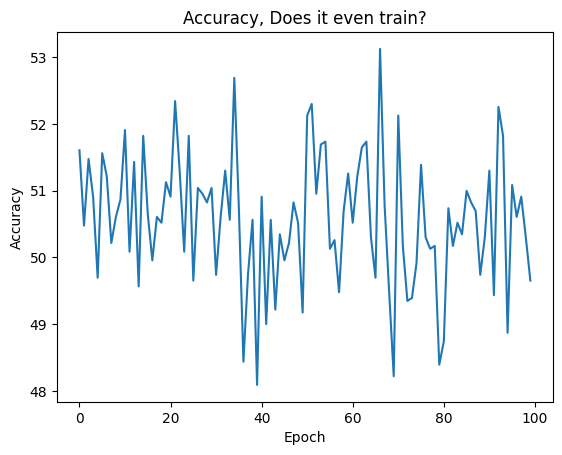

In [174]:
plt.plot(accuracy_list)
plt.title("Accuracy, Does it even train?")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")


Text(0.5, 0, 'Epoch')

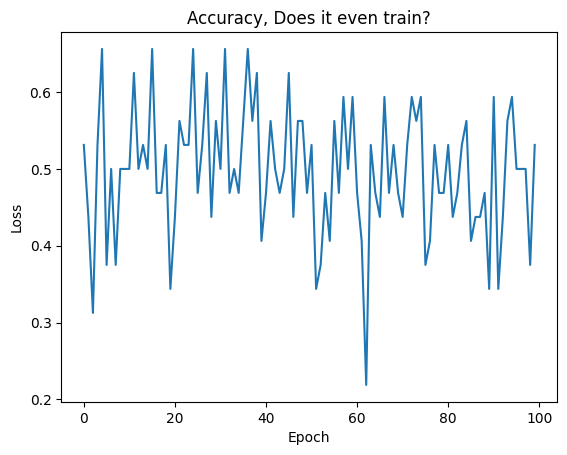

In [175]:
plt.plot(loss_list)
plt.title("Accuracy, Does it even train?")
plt.ylabel("Loss")
plt.xlabel("Epoch")




In [ ]:
model.eval()
test_loss = 0
correct = 0
sample_eval = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += nn.functional.binary_cross_entropy(output, target).item()
        pred = output
        correct += int(sum(pred.eq(target))[0])
        sample_eval += int(target.shape[0])

test_loss /= sample_eval
accuracy = 100.0 * correct / sample_eval

#Print the results for the current fold
print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{sample_eval} ({accuracy:.2f}%)\n")

end = time.time()
print(end - start) # time in seconds

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 32 but got size 2 for tensor number 1 in the list.